In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import matplotlib.pyplot as plt


# import VGG 19 model et keras Model API
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model


In [4]:
# Image Credits: Tensorflow Doc
content_path = tf.keras.utils.get_file(
'content.jpg',
'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file(
'style.jpg',
'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


195196/195196 [==============================] - 0s 0us/step


In [5]:
# Chargement et traitement d'image
def load_and_process_image(image_path):
	img = load_img(image_path)
	# convertir image en array
	img = img_to_array(img)
	img = preprocess_input(img)
	img = np.expand_dims(img, axis=0)
	return img


In [6]:
# code
def deprocess(img):
	img[:, :, 0] += 103.939
	img[:, :, 1] += 116.779
	img[:, :, 2] += 123.68
	# convertir RGB en BGR
	img = img[:, :, ::-1]

	img = np.clip(img, 0, 255).astype('uint8')
	return img


def display_image(image):
	# retirer une dimension si image a 4 dimension
	if len(image.shape) == 4:
		img = np.squeeze(image, axis=0)

	img = deprocess(img)

	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	plt.imshow(img)
	return


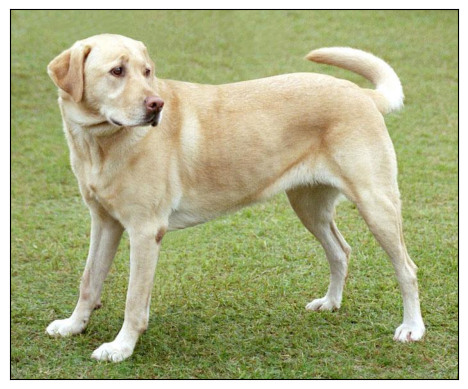

In [7]:
# Charger l'image de contenu
content_img = load_and_process_image(content_path)
display_image(content_img)


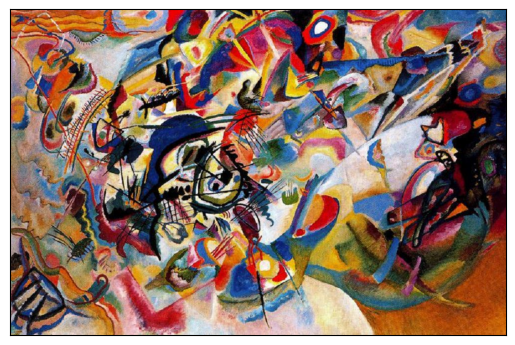

In [8]:
# Charger l'image de style
style_img = load_and_process_image(style_path)
display_image(style_img)


In [9]:
# code
# telechargement et initialisation du model VGG
model = VGG19(
	include_top=False,
	weights='imagenet'
)
# definir l'entrainement comme False
model.trainable = False


model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [10]:
# definition du model de contenu
content_layer = 'block5_conv2'
content_model = Model(
	inputs=model.input,
	outputs=model.get_layer(content_layer).output
)
content_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [11]:
# Definir le model du style
style_layers = [
	'block1_conv1',
	'block3_conv1',
	'block5_conv1'
]
style_models = [Model(inputs=model.input,
					outputs=model.get_layer(layer).output) for layer in style_layers]


In [12]:
# Perte du contenu
def content_loss(content, generated):
	a_C = content_model(content)
	a_G = content_model(generated) # Add this line to compute a_G
	loss = tf.reduce_mean(tf.square(a_C - a_G))
	return loss


In [13]:
# Applique l'activation
def gram_matrix(A):
	channels = int(A.shape[-1])
	a = tf.reshape(A, [-1, channels])
	n = tf.shape(a)[0]
	gram = tf.matmul(a, a, transpose_a=True)
	return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)


In [14]:
#Perte du style
def style_cost(style, generated):
	J_style = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_style += content_cost * weight_of_layer

	return J_style


In [15]:
#Perte du contenu
def content_cost(style, generated):
	J_content = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_content += content_cost * weight_of_layer

	return J_content


In [28]:
# fonction d'entrainement



def training_loop(content_path, style_path, iterations=40, a=10, b=1000):
	generated_images = []
	# Chargement des images avec leurs path respectifs
	content = load_and_process_image(content_path)
	style = load_and_process_image(style_path)
	generated = tf.Variable(content, dtype=tf.float32)

	opt = tf.keras.optimizers.Adam(learning_rate=7.0)

	best_cost = math.inf
	best_image = None
	for i in range(iterations):
		start_time_cpu = time.process_time()
		start_time_wall = time.time()
		with tf.GradientTape() as tape:
			J_content = content_cost(style, generated)
			J_style = style_cost(style, generated)
			J_total = a * J_content + b * J_style

		grads = tape.gradient(J_total, generated)
		opt.apply_gradients([(grads, generated)])

		end_time_cpu = time.process_time() 
		end_time_wall = time.time() wall time
		cpu_time = end_time_cpu - start_time_cpu 
		wall_time = end_time_wall - start_time_wall 

		if J_total < best_cost:
			best_cost = J_total
			best_image = generated.numpy()

		print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
		int(cpu_time * 1e6),
		int(( end_time_cpu - start_time_cpu) * 1e9),
		int((end_time_cpu - start_time_cpu + 1e-6) * 1e6))
			)

		print("Wall time: {:.2f} µs".format(wall_time * 1e6))
		print("Iteration :{}".format(i))
		print('Total Loss {:e}.'.format(J_total))
		generated_images.append(generated.numpy())

	return best_image


In [17]:
# Essaie
final_img = training_loop(content_path, style_path)


CPU times: user 274785506 µs, sys: 274785506126 ns, total: 274785507 µs
Wall time: 178433147.91 µs
Iteration :0
Total Loss 4.582239e+11.
CPU times: user 278346137 µs, sys: 278346137415 ns, total: 278346138 µs
Wall time: 179193705.32 µs
Iteration :1
Total Loss 3.113243e+11.
CPU times: user 272974861 µs, sys: 272974861824 ns, total: 272974862 µs
Wall time: 174818972.59 µs
Iteration :2
Total Loss 1.852609e+11.
CPU times: user 274503576 µs, sys: 274503576702 ns, total: 274503577 µs
Wall time: 175642922.40 µs
Iteration :3
Total Loss 1.519092e+11.
CPU times: user 273434667 µs, sys: 273434667360 ns, total: 273434668 µs
Wall time: 174420597.31 µs
Iteration :4
Total Loss 1.413674e+11.
CPU times: user 287489380 µs, sys: 287489380373 ns, total: 287489381 µs
Wall time: 186390340.81 µs
Iteration :5
Total Loss 1.074965e+11.
CPU times: user 274289031 µs, sys: 274289031968 ns, total: 274289032 µs
Wall time: 174099336.15 µs
Iteration :6
Total Loss 7.990628e+10.
CPU times: user 272424473 µs, sys: 272424

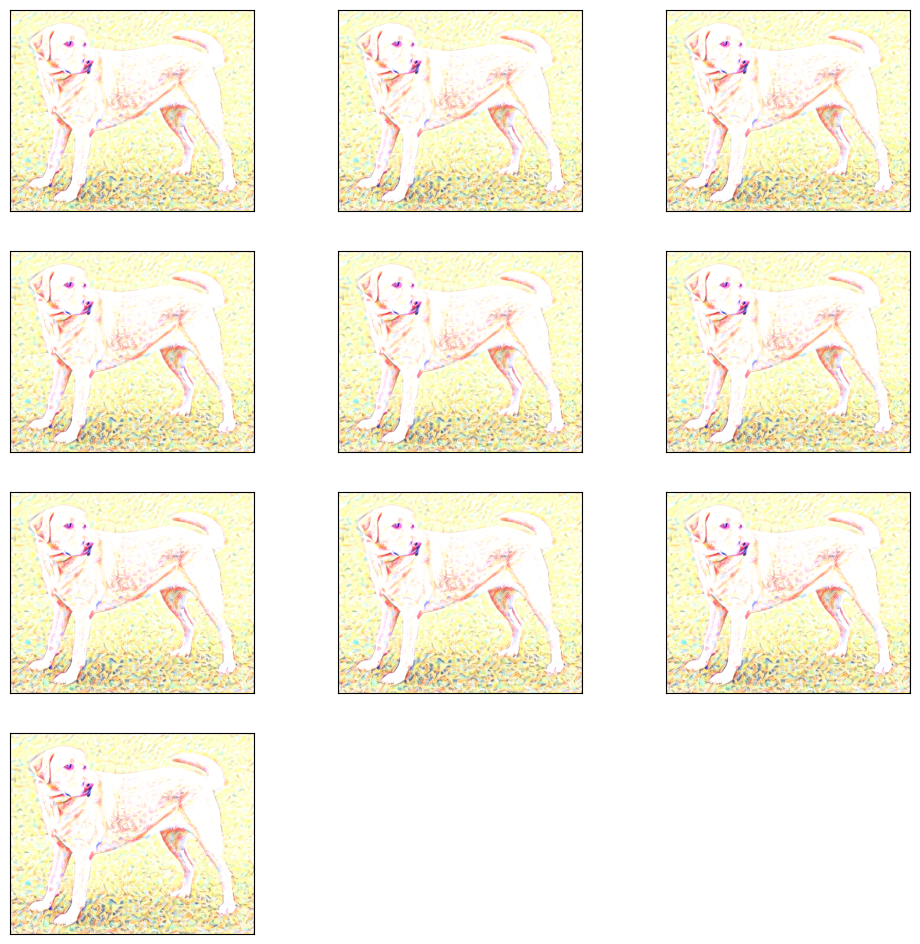

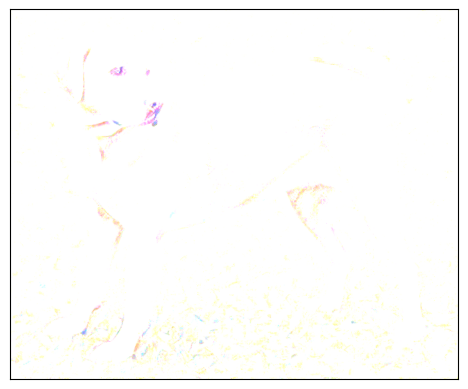

In [21]:
# Affichage des images
plt.figure(figsize=(12, 12))

for i in range(10):
	plt.subplot(4, 3, i + 1)
	display_image(generated_images[i+29])
plt.show()

display_image(final_img)


In [22]:
# Importation des images

image = []

ndop_path = tf.keras.utils.get_file(
'ndop.jpg',
'https://i.etsystatic.com/17755157/r/il/66a222/3663550068/il_570xN.3663550068_q631.jpg')
image.append(ndop_path)

toghu_path = tf.keras.utils.get_file(
'toghu.jpg',
'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSUwZyjJUmvAEdmm52MQLjYfppRXZvpeBIINfo52atY_DHfPGV7')
image.append(toghu_path)

leopard_path = tf.keras.utils.get_file(
'leopard.jpg',
'https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcT3r-ADrb38huBWLrokYT3LtfDlWdZ-x2lurxBD3PqSZMUbAgab')
image.append(leopard_path)

paysage_1_path = tf.keras.utils.get_file(
'paysage_1.jpg',
'https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcS4r62uWjbpqnnCSoSlWxrPQcEP8EP1gf1r39W-xgT9GqCVTZl4')

image.append(paysage_1_path)

paysage_2_path = tf.keras.utils.get_file(
'paysage_2.jpg',
'https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcRYEu38i0wQsqeMyQL3AYyvduTt-y13czKrcgG9lsbtKSMzqnyE')

image.append(paysage_2_path)

afro_paint_path = tf.keras.utils.get_file(
'afro_paint.jpg',
'https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcQaJnebkfy70cFL0YbmsQYck2fNDMTYdh5T5ttEG_H-SXXmkqnr')

image.append(afro_paint_path)

haut_path = tf.keras.utils.get_file(
'haut.jpg',
'https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcQj484tmGKi-hNjQPCSmrQs4HRmNA0f8YE8tqA6EIiBueOcXNRH')

image.append(haut_path)

chien_path = tf.keras.utils.get_file(
'chien.jpg',
'https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcQJtosK2IqSLgxnPUJiM-JISneRPsop_U11l2G_IjZLqvs6u_j8')

image.append(chien_path)

bichon_path = tf.keras.utils.get_file(
'bichon.jpg',
'https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcR5gaWnEM5AzJUMpoeCXj8WIAtnBPU5p_lS_ZI_oJUqfiLsaW-6')

image.append(bichon_path)

serpent_path = tf.keras.utils.get_file(
'serpent.jpg',
'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQuZy6OpAFprGDz76h6v12rZ4lz33FiXWXcy0MWhUts2mxtIhKh')

image.append(serpent_path)


17210/17210 [==============================] - 0s 0us/step


In [23]:
len(image)

10

CPU times: user 98110542 µs, sys: 98110542194 ns, total: 98110543 µs
Wall time: 62945481.54 µs
Iteration :0
Total Loss 4.240448e+12.
CPU times: user 94829630 µs, sys: 94829630885 ns, total: 94829631 µs
Wall time: 63069849.25 µs
Iteration :1
Total Loss 3.773114e+12.
CPU times: user 95178844 µs, sys: 95178844431 ns, total: 95178845 µs
Wall time: 59810527.32 µs
Iteration :2
Total Loss 2.961288e+12.
CPU times: user 95370080 µs, sys: 95370080845 ns, total: 95370081 µs
Wall time: 62465528.49 µs
Iteration :3
Total Loss 2.150676e+12.
CPU times: user 93870913 µs, sys: 93870913049 ns, total: 93870914 µs
Wall time: 59168763.16 µs
Iteration :4
Total Loss 1.577166e+12.
CPU times: user 93679045 µs, sys: 93679045943 ns, total: 93679046 µs
Wall time: 60117745.88 µs
Iteration :5
Total Loss 1.360805e+12.
CPU times: user 93149421 µs, sys: 93149421791 ns, total: 93149422 µs
Wall time: 61148523.33 µs
Iteration :6
Total Loss 1.240508e+12.
CPU times: user 92684028 µs, sys: 92684028552 ns, total: 92684029 µs


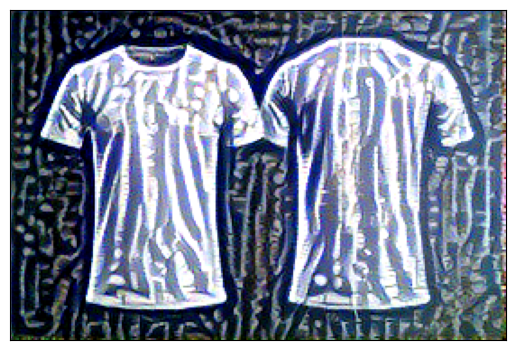

In [25]:
haut_ndop = training_loop(haut_path, ndop_path)

display_image(haut_ndop)

In [ ]:

haut_toghu = training_loop(haut_path, toghu_path)
display_image(haut_toghu)

CPU times: user 22809529 µs, sys: 22809529907 ns, total: 22809530 µs
Wall time: 14439723.97 µs
Iteration :0
Total Loss 8.760431e+12.
CPU times: user 24138958 µs, sys: 24138958847 ns, total: 24138959 µs
Wall time: 15321934.94 µs
Iteration :1
Total Loss 8.269650e+12.
CPU times: user 23611078 µs, sys: 23611078883 ns, total: 23611079 µs
Wall time: 15012802.36 µs
Iteration :2
Total Loss 7.219191e+12.
CPU times: user 23691070 µs, sys: 23691070888 ns, total: 23691071 µs
Wall time: 14890262.37 µs
Iteration :3
Total Loss 5.891950e+12.
CPU times: user 23856897 µs, sys: 23856897839 ns, total: 23856898 µs
Wall time: 15279528.38 µs
Iteration :4
Total Loss 4.570922e+12.
CPU times: user 23565710 µs, sys: 23565710628 ns, total: 23565711 µs
Wall time: 15550243.14 µs
Iteration :5
Total Loss 3.591381e+12.
CPU times: user 23456251 µs, sys: 23456251986 ns, total: 23456252 µs
Wall time: 14888955.83 µs
Iteration :6
Total Loss 3.127908e+12.
CPU times: user 23486238 µs, sys: 23486238273 ns, total: 23486239 µs


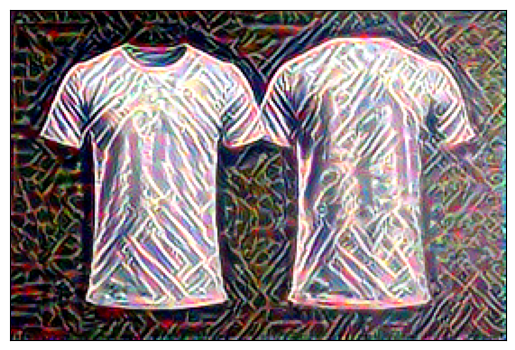

In [83]:
display_image(haut_toghu)

In [27]:
import pickle

In [29]:
with open('model_nst.pkl', 'wb') as file:
    pickle.dump(training_loop, file)

In [30]:
with open('model_nst.pkl', 'rb') as file:
    loaded_model_nst = pickle.load(file)

In [31]:
paysage_chien = loaded_model_nst(chien_path, paysage_1_path)

CPU times: user 23870125 µs, sys: 23870125891 ns, total: 23870126 µs
Wall time: 14932598.83 µs
Iteration :0
Total Loss 3.198870e+11.
CPU times: user 23639610 µs, sys: 23639610677 ns, total: 23639611 µs
Wall time: 14937026.26 µs
Iteration :1
Total Loss 1.509582e+11.
CPU times: user 23344729 µs, sys: 23344729772 ns, total: 23344730 µs
Wall time: 14811817.88 µs
Iteration :2
Total Loss 9.936577e+10.
CPU times: user 23766341 µs, sys: 23766341309 ns, total: 23766342 µs
Wall time: 15070755.00 µs
Iteration :3
Total Loss 8.500180e+10.
CPU times: user 23714304 µs, sys: 23714304209 ns, total: 23714305 µs
Wall time: 15133407.35 µs
Iteration :4
Total Loss 5.599416e+10.
CPU times: user 23923422 µs, sys: 23923422193 ns, total: 23923423 µs
Wall time: 15879827.26 µs
Iteration :5
Total Loss 3.972168e+10.
CPU times: user 23833520 µs, sys: 23833520796 ns, total: 23833521 µs
Wall time: 17000075.58 µs
Iteration :6
Total Loss 3.262847e+10.
CPU times: user 23685245 µs, sys: 23685245393 ns, total: 23685246 µs


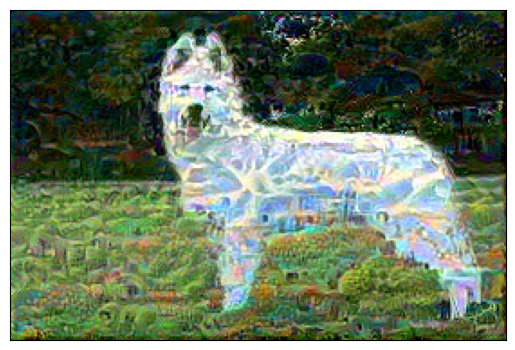

In [32]:
display_image(paysage_chien)

In [33]:
from google.colab import files

files.download('model_nst.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [86]:
chien_leopard = training_loop(chien_path, leopard_path)

CPU times: user 21999373 µs, sys: 21999373962 ns, total: 21999374 µs
Wall time: 15297126.53 µs
Iteration :0
Total Loss 3.089235e+12.
CPU times: user 21552364 µs, sys: 21552364373 ns, total: 21552365 µs
Wall time: 13564016.58 µs
Iteration :1
Total Loss 2.582305e+12.
CPU times: user 21638901 µs, sys: 21638901184 ns, total: 21638902 µs
Wall time: 13641252.52 µs
Iteration :2
Total Loss 1.980537e+12.
CPU times: user 21676151 µs, sys: 21676151040 ns, total: 21676152 µs
Wall time: 13474963.19 µs
Iteration :3
Total Loss 1.453447e+12.
CPU times: user 21625395 µs, sys: 21625395341 ns, total: 21625396 µs
Wall time: 13333066.23 µs
Iteration :4
Total Loss 1.105796e+12.
CPU times: user 21637569 µs, sys: 21637569193 ns, total: 21637570 µs
Wall time: 14306204.32 µs
Iteration :5
Total Loss 9.294833e+11.
CPU times: user 21677860 µs, sys: 21677860165 ns, total: 21677861 µs
Wall time: 13630282.88 µs
Iteration :6
Total Loss 8.049171e+11.
CPU times: user 21648287 µs, sys: 21648287259 ns, total: 21648288 µs


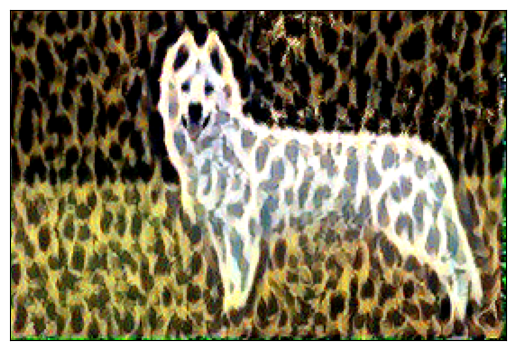

In [87]:
display_image(chien_leopard)